This file explores how to make a flyable device, and a plan that can be called by the run engine. 

In [1]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
token=RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

1

In [2]:
import numpy as np
import os
import random
import threading
import time as ttime
import uuid
import weakref
import warnings

from collections import deque, OrderedDict
from tempfile import mkdtemp

from ophyd.signal import Signal, EpicsSignal, EpicsSignalRO
from ophyd.areadetector.base import EpicsSignalWithRBV
from ophyd.status import DeviceStatus, StatusBase
from ophyd.device import (Device, Component as Cpt,
                     DynamicDeviceComponent as DDCpt, Kind)
from types import SimpleNamespace
from ophyd.pseudopos import (PseudoPositioner, PseudoSingle,
                        real_position_argument, pseudo_position_argument)
from ophyd.positioner import SoftPositioner
from ophyd.utils import ReadOnlyError, LimitError

In [3]:
from ophyd import PVPositioner, EpicsSignal, EpicsSignalRO, Device, DerivedSignal,PseudoPositioner,PseudoSingle, Signal
from ophyd import Component as Cpt
from ophyd.flyers import MonitorFlyerMixin

A flyable device has to have kickoff, complete, describe_collect, and collect methods. https://blueskyproject.io/ophyd/architecture.html#fly-able-interface

In [4]:
from ophyd.status import SubscriptionStatus, wait

In [5]:
from ophyd.utils import OrderedDefaultDict
from ophyd.status import SubscriptionStatus, DeviceStatus
from ophyd import Device
import time

class BasicFlyer(Device):   


    def __init__(self, prefix, *args, **kwargs):
        super().__init__(prefix, parent=None, **kwargs)
        self.complete_status = None
        self._acquiring = False
        self.t0 = 0
          
    def kickoff(self):
        """
        Start this Flyer, return a status object that sets finished once we have started
        """
        self.kickoff_status = DeviceStatus(self)
        self.complete_status = DeviceStatus(self)
        self._acquiring = True
        self.t0 = time.time()

        if self.init_cmd is not None:
            self.init_cmd.put(1)
        
        def check_value(*,old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.   
            if not self._acquiring:  #But only report done if acquisition was already started 
                return False
            return (value != 0)
        
        wait(SubscriptionStatus(self.ready, check_value,settle_time=0.2))
        
        # TODO: do the activity here
        if self.start_cmd is not None:
            self.start_cmd.put(1)
        # once started, we notify by updating the status object
        self.kickoff_status._finished(success=True)

        return self.kickoff_status

    def pause(self):

        self.stop_cmd.put(1)

    def resume(self):

        self.start_cmd.put(1)

    def stop(self, *, success=False):
        self.stop_cmd.put(1)
    

    def complete(self):
        """
        Wait for flying to be complete, get the status object that will tell us when we are done
        """
        def check_value(*,old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.   
            if not self._acquiring:  #But only report done if acquisition was already started 
                return False
            return (value != 0)

        self.complete_status = SubscriptionStatus(self.done,check_value)

        return self.complete_status

    def collect(self):
        """
        Retrieve the data
        """
        # This is dummy data to test the formation of a list
        self.complete_status = None
        for _ in range(5):
            t = time.time()
            x = t - self.t0 
            d = dict(
                time=t,
                data={self.name+'_pos':x},
                timestamps=dict(x=t)
            )
            yield d
        
    
    def describe_collect(self):
 
        """
        Describe details for ``collect()`` method
        """
        d = dict(
            source = "elapsed time, s",
            dtype = "number",
            shape = []
        )
        return {
            self.name: {
                self.name+'_pos': d
            }
        }


class MyDetector(Device):
    
    count =  Cpt(EpicsSignalRO,'sensor4:getCount', kind='hinted') 

class MyMotor(BasicFlyer):
    
    start_pos = Cpt(EpicsSignal,'axis4:setStartPos', kind='config') 
    end_pos = Cpt(EpicsSignal,'axis4:setEndPos', kind='config')
    pos = Cpt(EpicsSignalRO,'axis4:getPos', kind='hinted') 
    velocity = Cpt(EpicsSignal,'axis4:setVel', kind='config')
    start_cmd = Cpt(EpicsSignal, 'axis4:start.PROC', kind='config')
    stop_cmd = Cpt(EpicsSignal, 'axis4:stop.PROC', kind='config')
    init_cmd = Cpt(EpicsSignal, 'axis4:init.PROC', kind='config')
    done = Cpt(EpicsSignal, 'axis4:done', kind='config')
    ready = Cpt(EpicsSignal, 'axis4:ready', kind='config')
    
    read_attrs = ['pos']
    
my_det = MyDetector('EMILEL:TestIOC00:', name='my_det')
fdev = MyMotor('EMILEL:TestIOC00:', name='fdev')
fdev.wait_for_connection()

Now we want to make a plan which will perform a count, and create events at every count interval. 

In [6]:
from bluesky import plan_stubs as bps
from bluesky import preprocessors as bpp
from functools import partial


def flycount(detectors, num=1, delay=None, *, per_shot=None, md=None):
    """
    Take one or more readings from detectors.

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1

        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::

           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...

    md : dict, optional
        metadata

    """

    if per_shot is None:
        per_shot = bps.one_shot

    @bpp.stage_decorator(detectors)
    @bpp.run_decorator(md=md)
    def inner_count():
        return (yield from bps.repeat(partial(per_shot, detectors),
                                      num=num, delay=delay))

    return (yield from inner_count())

In [7]:
from bluesky.plans import count

def flyscan(detectors, flyer, start_val=None, stop_val=None, num=100, delay=0.1,*, md=None):
    
    """
    count detectors while flying a flyer with start, stop, num and rate 

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    flyer :
        Object of FlyerDevice type
    start_val : integer
        The start value fo the flyer
    stop_val : integer
        The stop value of the flyer
    num : integer
        The number of points in the scan
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.1
    md : dict, optional
        metadata

    """
    
    # TODO
    # Add test that detectors is a list longer than 0
    
    #Add the flyer to the list of things we want to count
    detectors_list = detectors.append(flyer)
    print(detectors_list)
    #Create the flycount wrapper to count while we fly
    
    
    
    #Define the motor metadata (important for plotting)
    motor = flyer
    md = md or {}
    _md = {'detectors': [det.name for det in detectors],
           'motors': flyer.name,
           'num_points': num,
           'num_intervals': num - 1,
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motors' : flyer.name,
                         'start': start_val, 
                         'stop' : stop_val,
                         'num' : num,
                         'delay': delay
                         },

           'plan_name': 'flycount',
           'hints': {},
       }
    _md.update(md or {})
    
    # Deterime the name of the x axis from the flyer
    x_fields = []
    x_fields.extend(getattr(motor, 'hints', {}).get('fields', []))
    default_dimensions = [(x_fields, 'primary')]
    default_hints = {}
    
    # The following is left from the scan plan implementation, assumes multiple motors
    if len(x_fields) > 0:
        default_hints.update(dimensions=default_dimensions)

    # now add default_hints and override any hints from the original md (if
    # exists)
    
    _md['hints'] = default_hints
    _md.update(md)
  
    # Configure the flyer (but don't yet init or start)
    flyer.start_pos.put(start_val)
    flyer.end_pos.put(stop_val)
    
    # Determine the requested velocity
    vel_req = abs(start_val-stop_val)/(delay*num)
    temp_num = num
    # Play with velocity limits
    if vel_req > 0.5:
        print("Velocity Request too high, increasing number of samples")
        vel_req = 0.5
        temp_num = int(abs(start_val-stop_val)/(delay*vel_req))
        print("num = "+ str(temp_num))
    flyer.velocity.put(vel_req)
    
    fly_and_count = bpp.fly_during_wrapper(count(detectors,num=temp_num,delay=delay),[fdev])
                                           
    yield from fly_and_count
    

None


Transient Scan ID: 1     Time: 2021-07-16 13:16:10
Persistent Unique Scan ID: 'b9bbf1c8-6458-4a53-9e41-c22333ddd6ff'
New stream: 'primary'
+-----------+------------+--------------+------------+
|   seq_num |       time | my_det_count |   fdev_pos |
+-----------+------------+--------------+------------+
|         1 | 13:16:10.8 |        15063 |      0.500 |
|         2 | 13:16:11.0 |        16520 |      0.578 |
|         3 | 13:16:11.2 |        19562 |      0.604 |
|         4 | 13:16:11.3 |        22746 |      0.656 |
|         5 | 13:16:11.4 |        22746 |      0.682 |
|         6 | 13:16:11.5 |        26039 |      0.708 |
|         7 | 13:16:11.7 |        26039 |      0.734 |
|         8 | 13:16:11.8 |        29405 |      0.760 |
|         9 | 13:16:11.9 |        29405 |      0.786 |
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to 

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


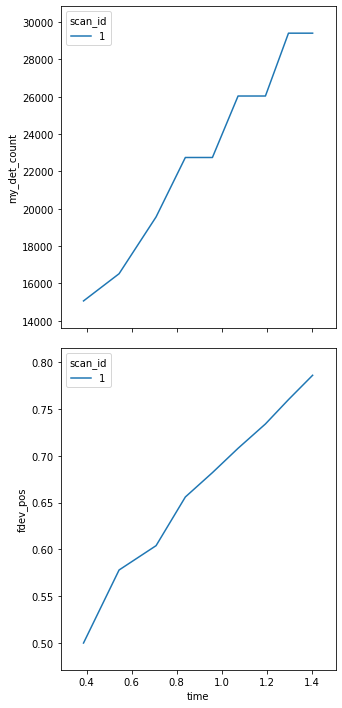

In [8]:
from ophyd.sim import det
dets = [my_det]
RE(flyscan(dets,fdev, 0.5, 3.1, 100))

Run aborted
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/run_engine.py", line 1342, in _run
    stashed_exception or resp)
  File "<ipython-input-7-cf5fa6f4d29a>", line 90, in flyscan
    yield from fly_and_count
bluesky.utils.PlanHalt


Halting: skipping cleanup and marking exit_status as 'abort'...
New stream: 'fdev'
+-----------+------------+--------------+------------+
generator count ['b9bbf1c8'] (scan num: 1)


/opt/tljh/user/lib/python3.7/site-packages/event_model/__init__.py:209: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  "The document type 'bulk_events' has been deprecated in favor of "


LivePlot did not get any data that corresponds to the x axis. time
LivePlot did not get any data that corresponds to the y axis. fdev_pos





('b9bbf1c8-6458-4a53-9e41-c22333ddd6ff',)

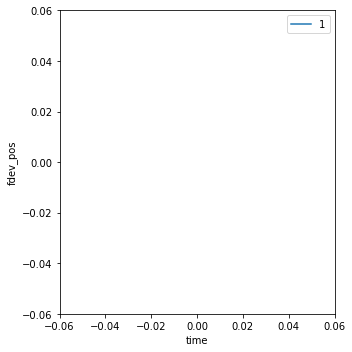

In [9]:
RE.halt()

In [8]:
run=db[-1]
run.primary.read()


<xarray.Dataset>
Dimensions:       (time: 73)
Coordinates:
  * time          (time) float64 1.626e+09 1.626e+09 ... 1.626e+09 1.626e+09
Data variables:
    fdev_pos      (time) float64 0.5 0.5026 0.5052 ... 0.6846 0.6872 0.6898
    my_det_count  (time) float64 1.506e+04 1.506e+04 ... 2.621e+04 2.621e+04

In [8]:
RE.resume()


|        20 | 11:06:12.7 |      0.562 |        18633 |
|        21 | 11:06:12.8 |      0.565 |        18633 |
|        22 | 11:06:12.9 |      0.568 |        18787 |
|        23 | 11:06:13.0 |      0.570 |        18787 |
|        24 | 11:06:13.1 |      0.573 |        19096 |
|        25 | 11:06:13.2 |      0.575 |        19096 |
|        26 | 11:06:13.3 |      0.578 |        19406 |
|        27 | 11:06:13.4 |      0.581 |        19406 |
|        28 | 11:06:13.5 |      0.583 |        19718 |
|        29 | 11:06:13.6 |      0.586 |        19718 |
|        30 | 11:06:13.7 |      0.588 |        20031 |
|        31 | 11:06:13.8 |      0.591 |        20031 |
|        32 | 11:06:13.9 |      0.594 |        20346 |
|        33 | 11:06:14.0 |      0.596 |        20346 |
|        34 | 11:06:14.1 |      0.599 |        20662 |
|        35 | 11:06:14.2 |      0.601 |        20662 |
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [ ]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


In [208]:
my_det.read_attrs

['count']

In [209]:
fdev.read_attrs

['pos']

In [23]:
run=db[-1]
run.primary.read()

<xarray.Dataset>
Dimensions:            (time: 10)
Coordinates:
  * time               (time) float64 1.626e+09 1.626e+09 ... 1.626e+09
Data variables:
    my_det_count       (time) float64 1.506e+04 1.506e+04 ... 5.782e+03
    my_readback_count  (time) float64 0.5 1.02 1.28 1.54 ... 2.58 2.84 2.84 2.84

Run aborted
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/utils.py", line 1127, in dec_inner
    return (yield from plan)
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/preprocessors.py", line 861, in fly_during_wrapper
    return (yield from plan2)
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/tljh/user/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/tljh/user/lib/python3.7/site-

Aborting: running cleanup and marking exit_status as 'abort'...
New stream: 'fdev'
LivePlot did not get any data that corresponds to the x axis. time
LivePlot did not get any data that corresponds to the y axis. fdev_pos





/opt/tljh/user/lib/python3.7/site-packages/event_model/__init__.py:209: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  "The document type 'bulk_events' has been deprecated in favor of "


('ac7bc405-4a8b-47a1-b378-69bd5648bbe2',)

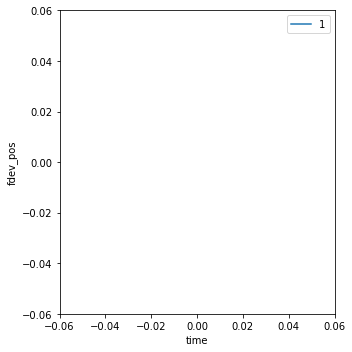

In [14]:
RE.abort()

In [9]:
#fdev.describe()

fdev.describe_collect()





{'fdev_pos': OrderedDict([('fdev_pos',
               {'source': 'PV:EMILEL:TestIOC00:axis4:getPos',
                'dtype': 'array',
                'shape': [],
                'units': '',
                'lower_ctrl_limit': 0.0,
                'upper_ctrl_limit': 0.0,
                'precision': 0})]),
 'fdev_count': OrderedDict([('fdev_count',
               {'source': 'PV:EMILEL:TestIOC00:sensor4:getCount',
                'dtype': 'array',
                'shape': [],
                'units': '',
                'lower_ctrl_limit': 0.0,
                'upper_ctrl_limit': 0.0,
                'precision': 0})])}

In [10]:
fdev.describe()

OrderedDict([('fdev_count',
              {'source': 'PV:EMILEL:TestIOC00:sensor4:getCount',
               'dtype': 'number',
               'shape': [],
               'units': '',
               'lower_ctrl_limit': 0.0,
               'upper_ctrl_limit': 0.0,
               'precision': 0}),
             ('fdev_start_pos',
              {'source': 'PV:EMILEL:TestIOC00:axis4:setStartPos',
               'dtype': 'number',
               'shape': [],
               'units': '',
               'lower_ctrl_limit': 0.0,
               'upper_ctrl_limit': 3.14,
               'precision': 0}),
             ('fdev_end_pos',
              {'source': 'PV:EMILEL:TestIOC00:axis4:setEndPos',
               'dtype': 'number',
               'shape': [],
               'units': '',
               'lower_ctrl_limit': 0.0,
               'upper_ctrl_limit': 3.14,
               'precision': 0}),
             ('fdev_velocity',
              {'source': 'PV:EMILEL:TestIOC00:axis4:setVel',
            

In [23]:
run = db[-1]
run.primary.metadata['descriptors'][0]['configuration']

{'fdev': {'data': {'fdev_start_pos': 0.5,
   'fdev_end_pos': 3.1,
   'fdev_velocity': 0.026000000000000002,
   'fdev_start_cmd': 1,
   'fdev_init_cmd': 1,
   'fdev_done': 0.0,
   'fdev_ready': 1.0},
  'timestamps': {'fdev_start_pos': 1625927797.149658,
   'fdev_end_pos': 1625927797.149662,
   'fdev_velocity': 1625927797.149827,
   'fdev_start_cmd': 1625927797.442671,
   'fdev_init_cmd': 1625927797.153572,
   'fdev_done': 1625927797.149841,
   'fdev_ready': 1625927797.240211},
  'data_keys': {'fdev_start_pos': {'source': 'PV:EMILEL:TestIOC00:axis4:setStartPos',
    'dtype': 'number',
    'shape': [],
    'units': '',
    'lower_ctrl_limit': 0.0,
    'upper_ctrl_limit': 3.14,
    'precision': 3},
   'fdev_end_pos': {'source': 'PV:EMILEL:TestIOC00:axis4:setEndPos',
    'dtype': 'number',
    'shape': [],
    'units': '',
    'lower_ctrl_limit': 0.0,
    'upper_ctrl_limit': 3.14,
    'precision': 3},
   'fdev_velocity': {'source': 'PV:EMILEL:TestIOC00:axis4:setVel',
    'dtype': 'number',


In [204]:
fdev.read_attrs



['pos']

In [31]:
fdev._collected_data['count']['values']

[0.0,
 0.0,
 418.0,
 1663.0,
 3702.0,
 6484.0,
 9938.0,
 13974.0,
 18491.0,
 23372.0,
 28494.0,
 33724.0,
 38930.0,
 43979.0,
 48741.0,
 53096.0,
 56930.0,
 60148.0,
 62666.0,
 64421.0,
 65367.0,
 65480.0,
 64757.0,
 63217.0,
 60900.0,
 57863.0,
 54186.0,
 49962.0,
 45298.0,
 40314.0,
 35137.0,
 29900.0,
 24736.0,
 19778.0,
 15151.0,
 10974.0,
 7354.0,
 4383.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.0,
 3165.

In [13]:
fdev.complete()

DeviceStatus(device=fdev, done=False, success=False)

In [14]:
fdev.describe_collect()

{'fdev_pos': OrderedDict([('fdev_pos',
               {'source': 'PV:EMILEL:TestIOC00:axis4:getPos',
                'dtype': 'array',
                'shape': [],
                'units': '',
                'lower_ctrl_limit': 0.0,
                'upper_ctrl_limit': 0.0,
                'precision': 0})]),
 'fdev_count': OrderedDict([('fdev_count',
               {'source': 'PV:EMILEL:TestIOC00:sensor4:getCount',
                'dtype': 'array',
                'shape': [],
                'units': '',
                'lower_ctrl_limit': 0.0,
                'upper_ctrl_limit': 0.0,
                'precision': 0})])}

In [15]:
data=fdev.collect()

In [16]:
#list(data) shows that this is the form we really want


In [17]:
list(data)

[{'time': 1625845803.2410402,
  'timestamps': {'fdev_pos': [1625845803.240136,
    1625845803.240136,
    1625845803.340201,
    1625845803.440138,
    1625845803.540225,
    1625845803.640168,
    1625845803.740191,
    1625845803.840148,
    1625845803.940086,
    1625845804.040142,
    1625845804.140163]},
  'data': {'fdev_pos': [0.0,
    0.0,
    0.04,
    0.08,
    0.12,
    0.16,
    0.2,
    0.24000000000000002,
    0.28,
    0.32,
    0.36]}},
 {'time': 1625845803.2410402,
  'timestamps': {'fdev_count': [1625845803.140023,
    1625845803.140023,
    1625845803.340034,
    1625845803.540039,
    1625845803.740025,
    1625845803.939993,
    1625845804.140035]},
  'data': {'fdev_count': [0.0, 0.0, 0.0, 418.0, 1663.0, 3702.0, 6484.0]}}]